# clustering

The procedure of supernode clustering with respect to different feature sets.

Requires:
1. `data/supernodes/supernodes.json`
2. `data/features/infrastructure_features.json`
3. `data/features/lspace_features.json`
4. `data/features/pspace_features.json`

Produces:
1. `data/clustering/clusters.json`

In [219]:
import sys
sys.path.append('..')

In [273]:
from typing import List

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from myutils.json import save_json

from config import supernodes_fpath, infrastructure_features_fpath, lspace_features_fpath, \
    pspace_features_fpath, supernode_clusters_fpath

In [221]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[4609, 29290, 3082, 17005, 16142, 15984, 16466...",0.331043,"[bus, trolley, tram]",60.017943,30.367853
1,"[16964, 4677, 19280, 2545, 49, 26803, 26804, 1...",0.237753,"[bus, tram, trolley, subway]",59.990263,30.254647


In [222]:
coords = supernodes[['lon', 'lat']].values

coords

array([[30.36785303, 60.01794322],
       [30.25464677, 59.99026319],
       [30.46852237, 59.91982784],
       ...,
       [30.39563275, 59.856488  ],
       [30.3612702 , 59.93006823],
       [30.3595223 , 59.9445053 ]])

In [223]:
infrastructure_features = pd.read_json(infrastructure_features_fpath).set_index('id')

# no_infrastructure_nodes = infrastructure_features[infrastructure_features['total'] == 0].index
# infrastructure_features = infrastructure_features.drop(index=no_infrastructure_nodes)

infrastructure_features = infrastructure_features.drop(columns=['total'])

infrastructure_features.head(2)

,residential_building,shop,catering_place,service,medicine,sight_place_tourism,education,sport,car_supply,company,organisation,supermarket,hotel_business,electronics_and_telecommunication,industrial,bank_and_money,printing_and_books,religion,post_office,business_center_or_mall_or_marketplace
id,,,,,,,,,,,,,,,,,,,,
0,0.493671,0.113924,0.037975,0.025316,0.050633,0.050633,0.075949,0.037975,0.000000,0.025316,0.025316,0.037975,0.0,0.000000,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000
1,0.014663,0.504399,0.140762,0.102639,0.029326,0.008798,0.008798,0.005865,0.017595,0.023460,0.005865,0.005865,0.0,0.026393,0.008798,0.008798,0.038123,0.008798,0.020528,0.020528


In [224]:
lspace_features = pd.read_json(lspace_features_fpath).set_index('id')

lspace_features.head(2)

,betw_centr,betw_centr_1hop_mean,betw_centr_2hop_mean,cl_centr,cl_centr_1hop_mean,cl_centr_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,degree,degree_1hop_mean,degree_2hop_mean
id,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,58,28.545455,29.580000
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,57,26.615385,19.571429


In [225]:
pspace_features = pd.read_json(pspace_features_fpath).set_index('id')

pspace_features.head(2)

,betw_centr,betw_centr_1hop_mean,betw_centr_2hop_mean,cl_centr,cl_centr_1hop_mean,cl_centr_2hop_mean,clustering,clustering_1hop_mean,clustering_2hop_mean,degree,degree_1hop_mean,degree_2hop_mean
id,,,,,,,,,,,,
0,0.012041,0.005576,0.005421,0.042311,0.041452,0.039940,0.308901,0.507988,0.629610,192,126.302083,94.013877
1,0.037970,0.006955,0.005211,0.044394,0.037900,0.040545,0.252879,0.583284,0.611572,230,109.925764,97.260572


In [226]:
graph_features = pd.concat(
    [
        lspace_features.rename(columns=lambda x: 'lspace_' + x),
        pspace_features.rename(columns=lambda x: 'pspace_' + x),
    ],
    axis=1,
)

graph_features.head(2)

,lspace_betw_centr,lspace_betw_centr_1hop_mean,lspace_betw_centr_2hop_mean,lspace_cl_centr,lspace_cl_centr_1hop_mean,lspace_cl_centr_2hop_mean,lspace_clustering,lspace_clustering_1hop_mean,lspace_clustering_2hop_mean,lspace_degree,...,pspace_betw_centr_2hop_mean,pspace_cl_centr,pspace_cl_centr_1hop_mean,pspace_cl_centr_2hop_mean,pspace_clustering,pspace_clustering_1hop_mean,pspace_clustering_2hop_mean,pspace_degree,pspace_degree_1hop_mean,pspace_degree_2hop_mean
id,,,,,,,,,,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,58,...,0.005421,0.042311,0.041452,0.039940,0.308901,0.507988,0.629610,192,126.302083,94.013877
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,57,...,0.005211,0.044394,0.037900,0.040545,0.252879,0.583284,0.611572,230,109.925764,97.260572


In [227]:
for col in graph_features.columns:
    if 'degree' in col:
        graph_features[col] /= graph_features[col].max()

In [228]:
all_features = pd.concat(
    [
        graph_features,
        infrastructure_features.rename(columns=lambda x: 'infr_' + x),
    ],
    axis=1,
)

all_features.head(2)

,lspace_betw_centr,lspace_betw_centr_1hop_mean,lspace_betw_centr_2hop_mean,lspace_cl_centr,lspace_cl_centr_1hop_mean,lspace_cl_centr_2hop_mean,lspace_clustering,lspace_clustering_1hop_mean,lspace_clustering_2hop_mean,lspace_degree,...,infr_organisation,infr_supermarket,infr_hotel_business,infr_electronics_and_telecommunication,infr_industrial,infr_bank_and_money,infr_printing_and_books,infr_religion,infr_post_office,infr_business_center_or_mall_or_marketplace
id,,,,,,,,,,,,,,,,,,,,,
0,0.008443,0.004129,0.019366,0.350325,0.328351,0.332136,0.127273,0.296357,0.164047,0.414286,...,0.025316,0.037975,0.0,0.000000,0.000000,0.012658,0.000000,0.000000,0.012658,0.000000
1,0.036374,0.017829,0.011287,0.346588,0.315883,0.302265,0.076923,0.197691,0.173053,0.407143,...,0.005865,0.005865,0.0,0.026393,0.008798,0.008798,0.038123,0.008798,0.020528,0.020528


In [229]:
all_features.isna().any().any()

False

## Clustering

In [230]:
def plot_inertia(array: np.ndarray):
    ks = np.arange(2, 20)
    inertia = []

    for k in tqdm(ks):
        kmeans = KMeans(n_clusters=k).fit(array)
        inertia.append(kmeans.inertia_)

    plt.plot(ks, inertia, lw=2, zorder=5)
    
    plt.xticks(ks, ks)
    plt.grid(ls='dotted')
    plt.title('KMeans inertia')
    
    plt.show()
    plt.close()

In [353]:
def plot_clusters(clusters: np.ndarray, tsne: np.ndarray, coords: np.ndarray):
    fig, axes = plt.subplots(ncols=2)
    fig.set_size_inches(12, 6)
    
    arrays = [tsne, coords]
    titles = ['tSNE', 'coordinates']
    
    for ax, array, title in zip(axes, arrays, titles):
        for i in np.unique(clusters):
            subarray = array[clusters == i]
            ax.scatter(*array[clusters == i].T, color=f'C{i}', s=7, label=f'cl. {i} (size {subarray.shape[0]})')
            
        ax.axis('off')
        ax.set_title(title)
            
    axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 1))

In [318]:
def get_cluster_feature_significance(
        features: pd.DataFrame,
        clusters: np.ndarray,
) -> pd.DataFrame:
    mean = features.mean(axis=0)
    std = features.std(axis=0)
    
    feature_significance = {}
    
    for i in np.unique(clusters):
        cluster = features[clusters == i]
        cluster_size = cluster.shape[0]
        cluster_mean = cluster.mean(axis=0)

        cluster_feature_significance = (cluster_mean - mean) / std * np.sqrt(cluster_size)
        feature_significance[i] = cluster_feature_significance

    feature_significance = pd.DataFrame(feature_significance).T
    
    return feature_significance

In [366]:
def plot_feature_significance(feature_significance):
    for _, row in feature_significance.iterrows():
        plt.plot(row.values)

    columns = pd.Series(feature_significance.columns)
    plt.xticks(columns.index, columns.values, rotation=90);
    plt.axhline(lw=1, c='k')
    plt.grid(ls='dotted')

## Infrastructure only

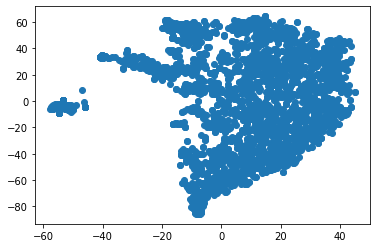

In [351]:
infrastructure_tsne = TSNE().fit_transform(infrastructure_features.values)

plt.scatter(*infrastructure_tsne.T)

100%|██████████| 18/18 [00:15<00:00,  1.19it/s]


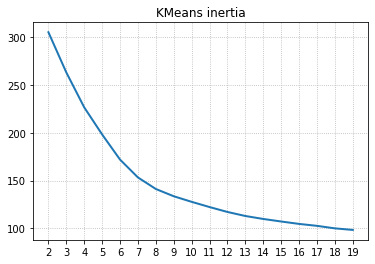

In [352]:
plot_inertia(infrastructure_features)

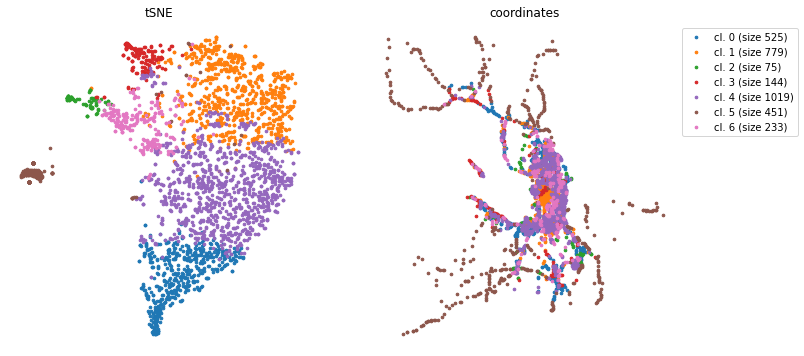

In [354]:
infrastructure_kmeans = KMeans(n_clusters=7).fit(infrastructure_features)
infrastructure_clusters = infrastructure_kmeans.predict(infrastructure_features)

plot_clusters(infrastructure_clusters, infrastructure_tsne, coords)

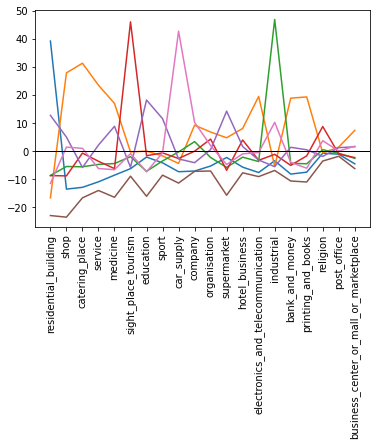

In [362]:
feature_significance = get_cluster_feature_significance(
    features=infrastructure_features,
    clusters=infrastructure_clusters,
)

plot_feature_significance(feature_significance)

Тут выделяются кластеры (7 шт.):

* Крайние остановки вообще без инфраструктуры.
* Спальники курильщика: жилые дома, а рядом нифига нет.
* Спальники здорового человека: жилые дома + больницы, школы, спортзалы, супермаркеты
* Сугубо туристические остановки.
* Остановки в промзонах.
* Промзона + car-related.
* Центр: магазины, рестораны, сервисы, больницы, БЦ, банки, книжные и пр.

## Graph features only

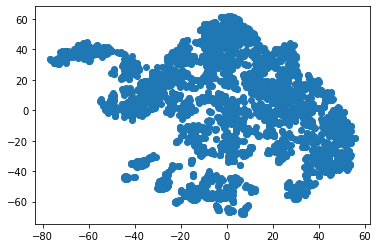

In [357]:
graph_tsne = TSNE().fit_transform(graph_features.values)

plt.scatter(*graph_tsne.T)

100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


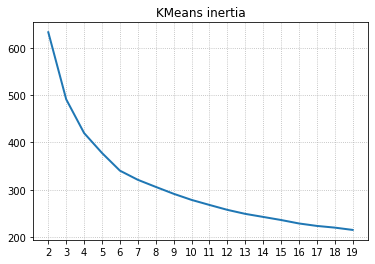

In [358]:
plot_inertia(graph_features.values)

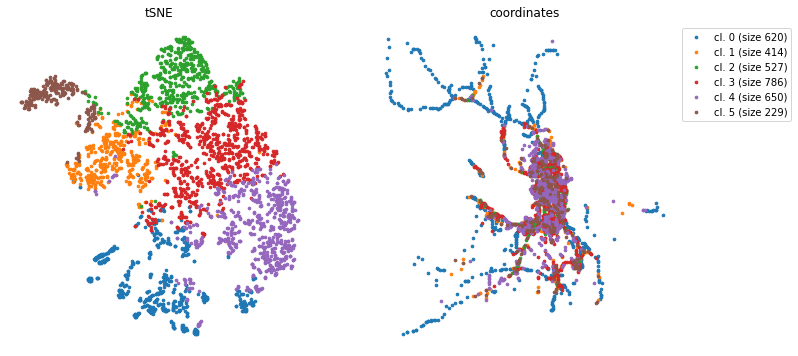

In [359]:
graph_kmeans = KMeans(n_clusters=6).fit(graph_features.values)
graph_clusters = graph_kmeans.predict(graph_features.values)

plot_clusters(graph_clusters, graph_tsne, coords)

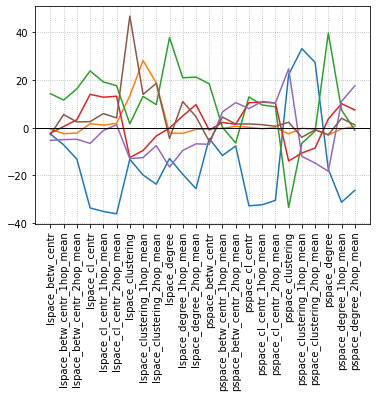

In [367]:
feature_significance = get_cluster_feature_significance(
    features=graph_features,
    clusters=graph_clusters,
)

plot_feature_significance(feature_significance)

## All features

***

In [350]:
clusters = pd.DataFrame({
    'id': infrastructure_features.index,
    'infrastructure': infrastructure_clusters,
    'graph': graph_clusters,
    # 'all': all_clusters,
})

clusters.head(2)

,id,infrastructure,graph
0,0,1,3
1,1,3,3


In [25]:
clusters_json = [row.to_dict() for _, row in clusters.iterrows()]

clusters_json[0]

{'id': 0, 'infrastructure': 1, 'graph': 2, 'all': 4}

In [26]:
save_json(clusters_json, supernode_clusters_fpath)